In [1]:
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
import matplotlib.pyplot as plt
import cv2
import numpy as np
import open3d as o3d
import itertools
import collections
from ultralytics import RTDETR
from ultralytics import SAM
from ultralytics import YOLO
import copy
import timeit

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#filename = '/storage/projects/AIMS5.0/stuff/uc6/data/ros2bag_02'
filename = '/storage/projects/AIMS5.0/stuff/uc6/data/rosbag2_2024_04_04-08_57_42' #rosbag2_2024_04_10-12_39_57'
#filename = '/ftp/rosbag2_2024_04_04-08_57_42/'
with Reader(filename) as reader:
    print(reader.start_time/1e9)
    print(reader.end_time/1e9)

1712221062.9103518
1712221084.6336033


In [3]:
data_all = collections.OrderedDict()
with Reader(filename) as reader:
    for connection, timestamp, rawdata in itertools.islice(reader.messages(start = 1712221075_910_351_800),50):  # start = 1712752801_000_000_000
        try:
            b = deserialize_cdr(rawdata, connection.msgtype)
            ts = b.header.stamp.sec * 1000000000 + b.header.stamp.nanosec

            if ts not in data_all:
                data_all[ts] = {}

            data_all[ts][connection.topic] = b
        except:
            pass

data = {k: v for k,v in data_all.items() if '/camera/aligned_depth_to_color/image_raw' in v and 
                                        '/camera/color/image_raw' in v and
                                         '/camera/aligned_depth_to_color/camera_info' in v }
                
for k,v in data.items():
    print(k)
    for o in v.keys():
        print(f'  {o}')

/tmp/ipykernel_952547/237362521.py:5: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  b = deserialize_cdr(rawdata, connection.msgtype)


1712221075695599609
  /camera/aligned_depth_to_color/camera_info
  /camera/aligned_depth_to_color/image_raw
  /camera/depth/color/points
  /camera/color/camera_info
  /camera/color/image_raw
1712221075895742188
  /camera/aligned_depth_to_color/camera_info
  /camera/aligned_depth_to_color/image_raw
  /camera/depth/color/points
  /camera/color/camera_info
  /camera/color/image_raw
  /camera/depth/camera_info
  /camera/depth/image_rect_raw
1712221075962456299
  /camera/aligned_depth_to_color/camera_info
  /camera/aligned_depth_to_color/image_raw
  /camera/depth/color/points
  /camera/color/camera_info
  /camera/color/image_raw
  /camera/depth/camera_info
  /camera/depth/image_rect_raw


In [4]:
data

{1712221075695599609: {'/camera/aligned_depth_to_color/camera_info': sensor_msgs__msg__CameraInfo(header=std_msgs__msg__Header(stamp=builtin_interfaces__msg__Time(sec=1712221075, nanosec=695599609, __msgtype__='builtin_interfaces/msg/Time'), frame_id='camera_color_optical_frame', __msgtype__='std_msgs/msg/Header'), height=720, width=1280, distortion_model='plumb_bob', d=array([          0,           0,           0,           0,           0]), k=array([     917.53,           0,      642.53,           0,      916.27,      357.79,           0,           0,           1]), r=array([          1,           0,           0,           0,           1,           0,           0,           0,           1]), p=array([     917.53,           0,      642.53,           0,           0,      916.27,      357.79,           0,           0,           0,           1,           0]), binning_x=0, binning_y=0, roi=sensor_msgs__msg__RegionOfInterest(x_offset=0, y_offset=0, height=0, width=0, do_rectify=False, __ms

In [5]:
data_entry = data[list(data.keys())[0]]
img_raw = data_entry['/camera/color/image_raw']
color_img = np.frombuffer(img_raw.data, dtype = np.uint8).reshape(img_raw.height, img_raw.width,3)
depth_raw = data_entry['/camera/aligned_depth_to_color/image_raw']
depth_img = np.frombuffer(depth_raw.data, dtype = np.uint16).reshape(depth_raw.height, depth_raw.width)
Kdepth = data_entry['/camera/aligned_depth_to_color/camera_info'].k.reshape(3,3)

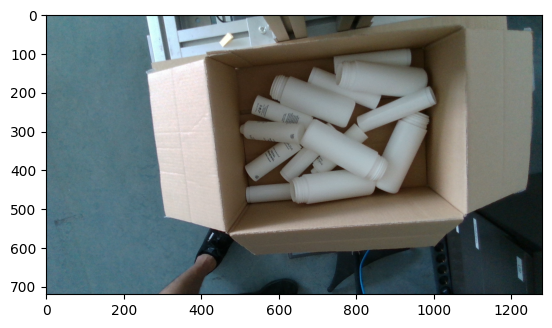

In [6]:
plt.imshow(color_img)

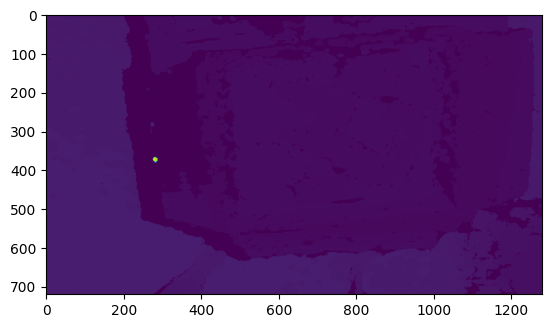

In [7]:
plt.imshow(depth_img)

In [8]:
# create point cloud
pts = cv2.rgbd.depthTo3d(depth_img, Kdepth)

In [9]:
# visualize point cloud
verts = pts.reshape((-1,3))
idx = ~np.isnan(verts).any(axis=1)
verts = verts[idx,:]
color = color_img.reshape((-1,3))
color = color[idx,:]

pcd = o3d.geometry.PointCloud()
orig_pcd = pcd
pcd.points = o3d.utility.Vector3dVector(verts)
pcd.colors = o3d.utility.Vector3dVector(color/255)
o3d.visualization.draw_geometries([pcd])

# Detection

In [10]:
det_model = RTDETR('rtdetr-x.pt')

In [11]:
# get cls indices for bottle and cup
cls_idxs = [id for id,name in det_model.names.items() if name in ['bottle','cup']]
cls_idxs

[39, 41]

In [12]:
results = det_model(color_img, classes = cls_idxs)
det_result = results[0]
len(det_result)

/storage/projects/AIMS5.0/stuff/uc6/src_ros/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0



0: 640x640 14 bottles, 1 cup, 3522.4ms
Speed: 83.5ms preprocess, 3522.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


15

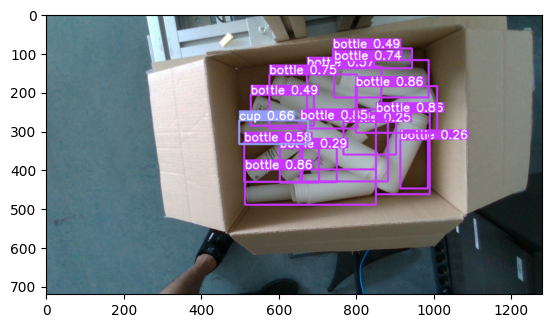

In [13]:
plt.imshow(det_result.plot())

In [14]:
sam = SAM('mobile_sam.pt')
#sam_result = sam.predict(color_img)[0]

In [15]:
sam_result = sam.predict(color_img, bboxes = det_result.boxes.xyxy)[0]


0: 1024x1024 4978.8ms
Speed: 22.1ms preprocess, 4978.8ms inference, 101.2ms postprocess per image at shape (1, 3, 1024, 1024)


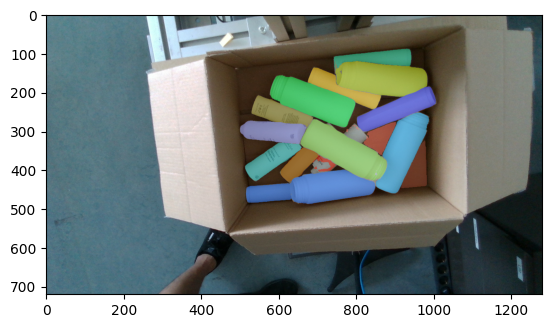

In [16]:
plt.imshow(sam_result.plot())

In [17]:
DOWN_SAMPLE_SIZE = 4e-3

In [18]:
ref_pcd = o3d.io.read_point_cloud("../bottle_large.pcd")
cnt = np.asarray(ref_pcd.points).shape[0]
ref_pcd.colors = o3d.utility.Vector3dVector(np.repeat([[1,0,0]],cnt,axis = 0).astype(np.float32))
#ref_pcd.transform(np.matrix("1,0,0,0; 0,0,-1,0; 0,1,0,0; 0,0,0,1"))
ref_pcd = ref_pcd.voxel_down_sample(DOWN_SAMPLE_SIZE)

In [19]:
def estimate_pose_for_mask(pts,color_img,mask):
    objpts = pts[mask,:]
    color = color_img[mask,:]

    #remove NaNs
    verts = objpts.reshape((-1,3))
    idx = ~np.isnan(verts).any(axis=1)
    verts = verts[idx,:]
    color = color[idx,:]

    # create PCD
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(verts)
    pcd.colors = o3d.utility.Vector3dVector(color/255)

    pcd_ds = pcd.voxel_down_sample(DOWN_SAMPLE_SIZE)

    pts_mean = np.mean(np.asarray(pcd_ds.points),axis=0)
    initial_transform = np.block([[np.identity(3), np.asmatrix(pts_mean).T],[0,0,0,1]])

    reg_p2p = o3d.pipelines.registration.registration_icp(
        ref_pcd, pcd_ds, 1, initial_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))


    reg_p2p = o3d.pipelines.registration.registration_icp(
        ref_pcd, pcd_ds, 0.01, reg_p2p.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))
    

    tvec = reg_p2p.transformation[0:3,3]
    rvec,_ = cv2.Rodrigues(reg_p2p.transformation[0:3,0:3])
    rvec = rvec.T[0,:]
    return tvec,rvec,reg_p2p


In [20]:
#estimate_pose_for_mask(pts,color_img,sam_result.masks[1].cpu().data.numpy())

results = [estimate_pose_for_mask(pts,color_img,mask.numpy()) for mask in sam_result.masks.data]


In [21]:
plt.rcParams['figure.figsize'] = [15, 7]

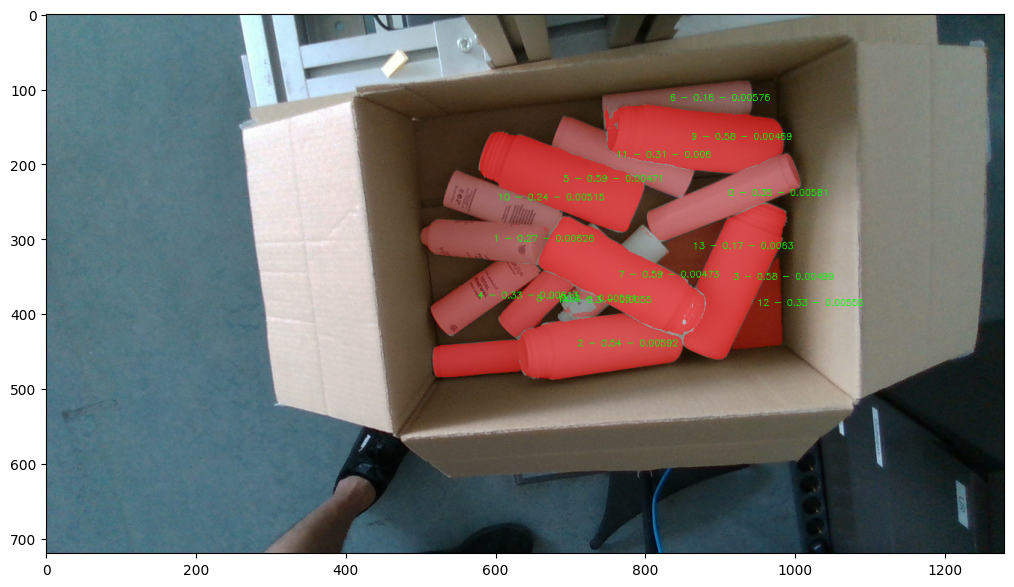

In [22]:
seg_debug_img = color_img.copy()

for id,(mask,result) in enumerate(zip(sam_result.masks,results)):
    mask = mask.data.numpy()[-1,:,:]

    blend = result[2].fitness
    seg_debug_img[mask,:] = (1 - blend) * seg_debug_img[mask,:] + (blend) * np.array([255,0,0])


for id,(mask,result) in enumerate(zip(sam_result.masks,results)):
    crd = np.mean(mask.xy,axis=1).astype(np.int32).flatten().tolist()
    text = f"{id} - {result[2].fitness:0.2} - {result[2].inlier_rmse:0.3}"
    cv2.putText(seg_debug_img,org=crd,text=text,fontFace = 0, fontScale = 0.4, color = (0,255,0), thickness = 1)

plt.imshow(seg_debug_img)

In [23]:
filtered_results = filter(lambda x: x[2].fitness > 0.5, results)

In [24]:
def generate_ref_point_cloud(transform):
    ref_pcd_temp = copy.deepcopy(ref_pcd)
    return ref_pcd_temp.transform(transform)

In [ ]:
pcd_all = [generate_ref_point_cloud(reg_res.transformation) for _,_,reg_res in filtered_results]
o3d.visualization.draw_geometries([pcd, *pcd_all])

In [118]:
# find the best by fitness
all_fitness = [res[2].fitness for res in results]
best_pcd_idx = all_fitness.index(max(all_fitness))

In [ ]:
pcd_best = generate_ref_point_cloud(results[best_pcd_idx][2].transformation)
o3d.visualization.draw_geometries([pcd, pcd_best])